In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='3'
import tensorflow as tf
from tensorflow.keras import layers
import keras_tuner as kt

## Data import

In [8]:
data = pd.read_csv('../Data/LT_DU_data_for_ML.csv')
data.head()

,nace,esize_class,gender,age_class,lpk,education,experience,target
0,C,1_49,M,40-49,p721,G2,13,8.20
1,C,1_49,F,40-49,p334,G2,0,2.51
2,M,50_249,F,40-49,p522,G2,18,2.19
3,M,50_249,F,40-49,p522,G2,12,2.19
4,M,50_249,F,14-29,p522,G2,0,2.19


## Spliting of dataframes for training, validation and testing

In [9]:
train, val, test = np.split(data.sample(frac=1), [int(0.7*len(data)), int(0.8*len(data))])
print(train.shape, val.shape, test.shape)

(22850, 8) (3264, 8) (6529, 8)


## Preprocessing functions
Based on: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers#create_compile_and_train_the_model

In [10]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe
  #df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value.to_numpy()[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

### Normalization of numeric features

In [11]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

### Encoding of string features

In [12]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

## Preprocessing

In [13]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [14]:
all_inputs = []
encoded_features = []

In [15]:
# Numerical features.
for header in ['experience']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [16]:
categorical_cols = ['nace', 'esize_class', 'gender', 'age_class', 'education', 'lpk']
for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string')
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

# Model and predictions

In [17]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(all_features)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [18]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=10000,
  decay_rate=1,
  staircase=False)

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

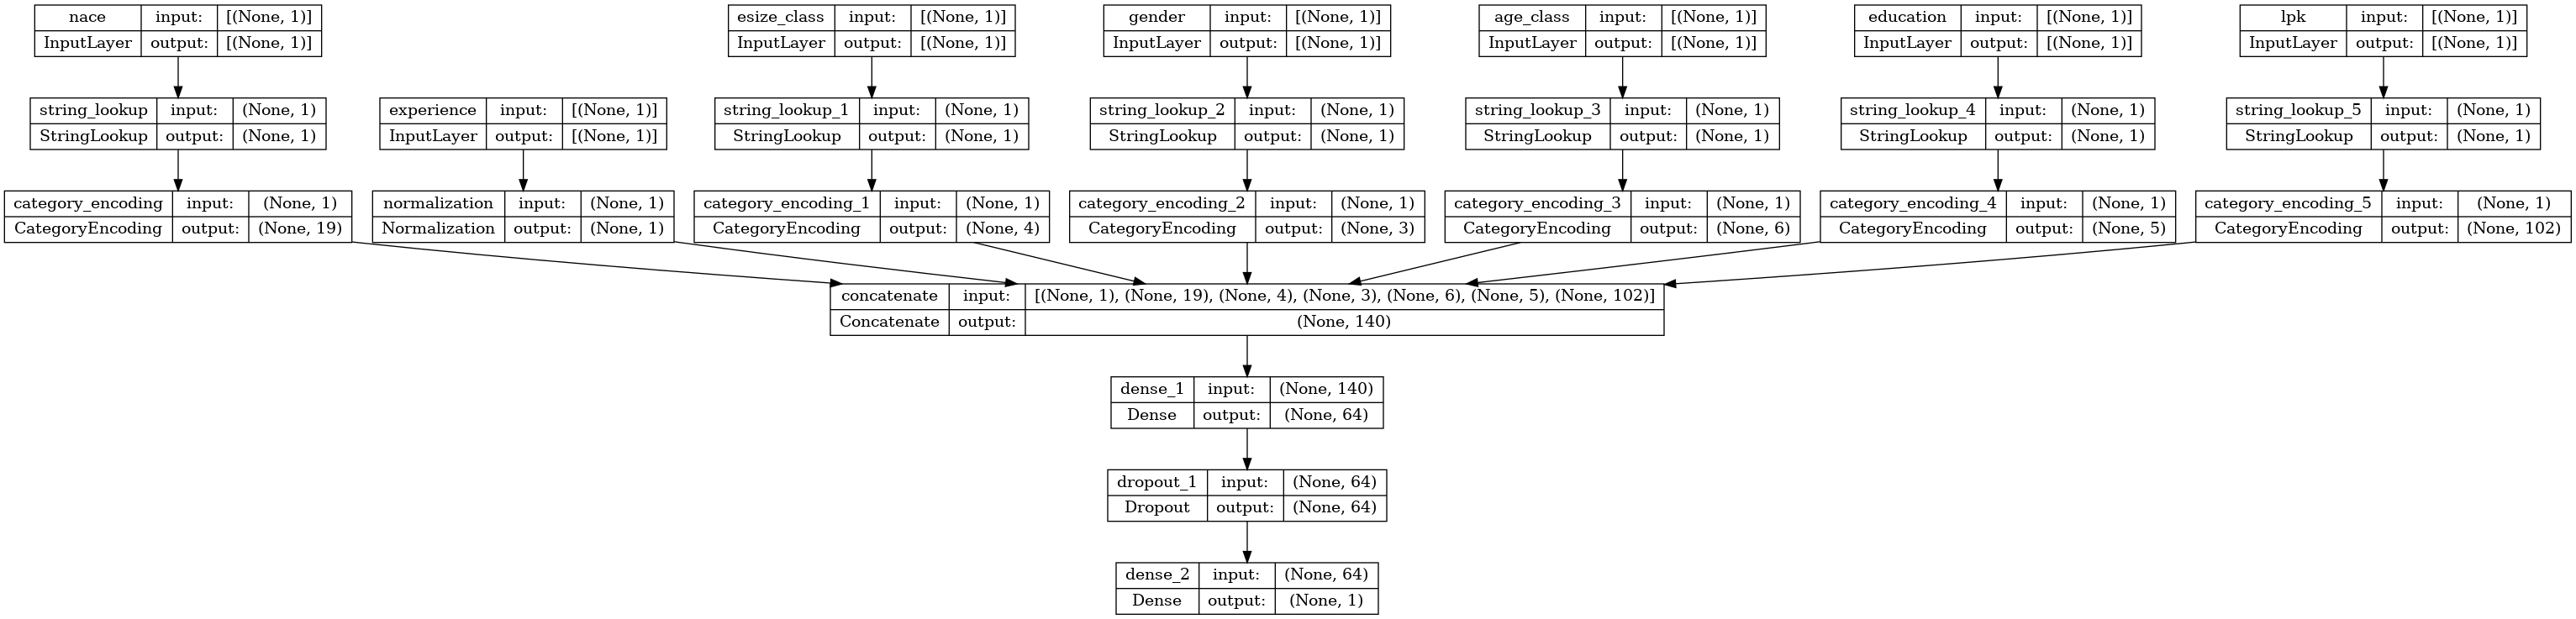

In [20]:
tf.keras.utils.plot_model(model, rankdir="TB", show_shapes=True)

In [21]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=30, 
    restore_best_weights=True,
)

In [22]:
history = model.fit(train_ds,
    validation_data=val_ds,
    epochs=300,
    callbacks=[early_stopping],
    verbose=0
)

Minimum validation RMSE: 1.6893317699432373


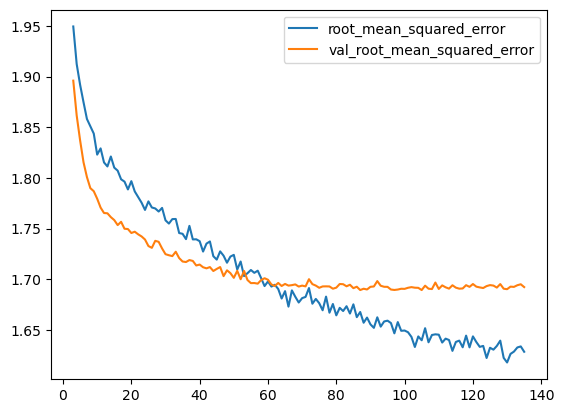

In [23]:
history_df = pd.DataFrame(history.history)
history_df.loc[3:, ['root_mean_squared_error', 'val_root_mean_squared_error']].plot();
print("Minimum validation RMSE: {}".format(history_df['val_root_mean_squared_error'].min()))

In [24]:
loss, rmse = model.evaluate(test_ds)

26/26 [==============================] - 0s 1ms/step - loss: 2.5537 - root_mean_squared_error: 1.5980


# Hypertuning

https://haneulkim.medium.com/hyperparameter-tuning-with-keras-tuner-full-tutorial-f8128397e857

In [25]:
def build_model(hp):
     
    all_features = tf.keras.layers.concatenate(encoded_features)
    # create hidden layers
    l2 = hp.Float('l2', min_value=1e-4, max_value=1e-2, sampling='log')
    units = hp.Int(f"0_units", min_value=16, max_value=96, step=16)
    dense = tf.keras.layers.Dense(units=units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2))(all_features)
    hp_drop_rate = hp.Choice('1_dropout_rate',values=[0.1, 0.2, 0.3])
    dense = tf.keras.layers.Dropout(rate=hp_drop_rate)(dense)
    units = hp.Int(f"1_units", min_value=16, max_value=96, step=16)
    dense = tf.keras.layers.Dense(units=units, activation='relu')(dense)
    hp_drop_rate = hp.Choice('2_dropout_rate',values=[0.1, 0.2, 0.3])
    dense = tf.keras.layers.Dropout(rate=hp_drop_rate)(dense)
    output = tf.keras.layers.Dense(units=1)(dense)
    
    
    model = tf.keras.Model(all_inputs, output)

    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='log')         
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

In [26]:
import shutil
path_to_dir = './tf_turner/LTDU_tf_hp'
if os.path.exists(path_to_dir) and os.path.isdir(path_to_dir):
    shutil.rmtree(path_to_dir)


In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=10, 
    restore_best_weights=True,
)

def build_tuner(model, hpo_method, objective, dir_name, project):
    if hpo_method == "RandomSearch":
        tuner = kt.RandomSearch(model, objective=objective, max_trials=5, executions_per_trial=1,
                               project_name=project, directory=dir_name)
    elif hpo_method == "Hyperband":
        tuner = kt.Hyperband(model, objective=objective, max_epochs=50, executions_per_trial=1,
                            project_name=project, directory=dir_name)
    elif hpo_method == "BayesianOptimization":
        tuner = kt.BayesianOptimization(model, objective=objective, max_trials=3, executions_per_trial=1,
                                       project_name=project, directory=dir_name)
    return tuner
  
obj = kt.Objective('val_root_mean_squared_error', direction='min')
dir_name = 'tf_turner'
tuner = build_tuner(build_model, "Hyperband", obj, dir_name, project='LTDU_tf_hp')
tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[early_stopping])

Trial 90 Complete [00h 00m 18s]
val_root_mean_squared_error: 1.721380352973938

Best val_root_mean_squared_error So Far: 1.6716169118881226
Total elapsed time: 00h 05m 22s
INFO:tensorflow:Oracle triggered exit


In [28]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
l2 (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
0_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 96, 'step': 16, 'sampling': None}
1_dropout_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
1_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 96, 'step': 16, 'sampling': None}
2_dropout_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3], 'ordered': True}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [29]:
best_trails = tuner.results_summary(1)

Results summary
Results in tf_turner/LTDU_tf_hp
Showing 1 best trials
Trial summary
Hyperparameters:
l2: 0.00018250490688078962
0_units: 64
1_dropout_rate: 0.2
1_units: 32
2_dropout_rate: 0.3
learning_rate: 0.0010241124557412876
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 1.6716169118881226


In [30]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

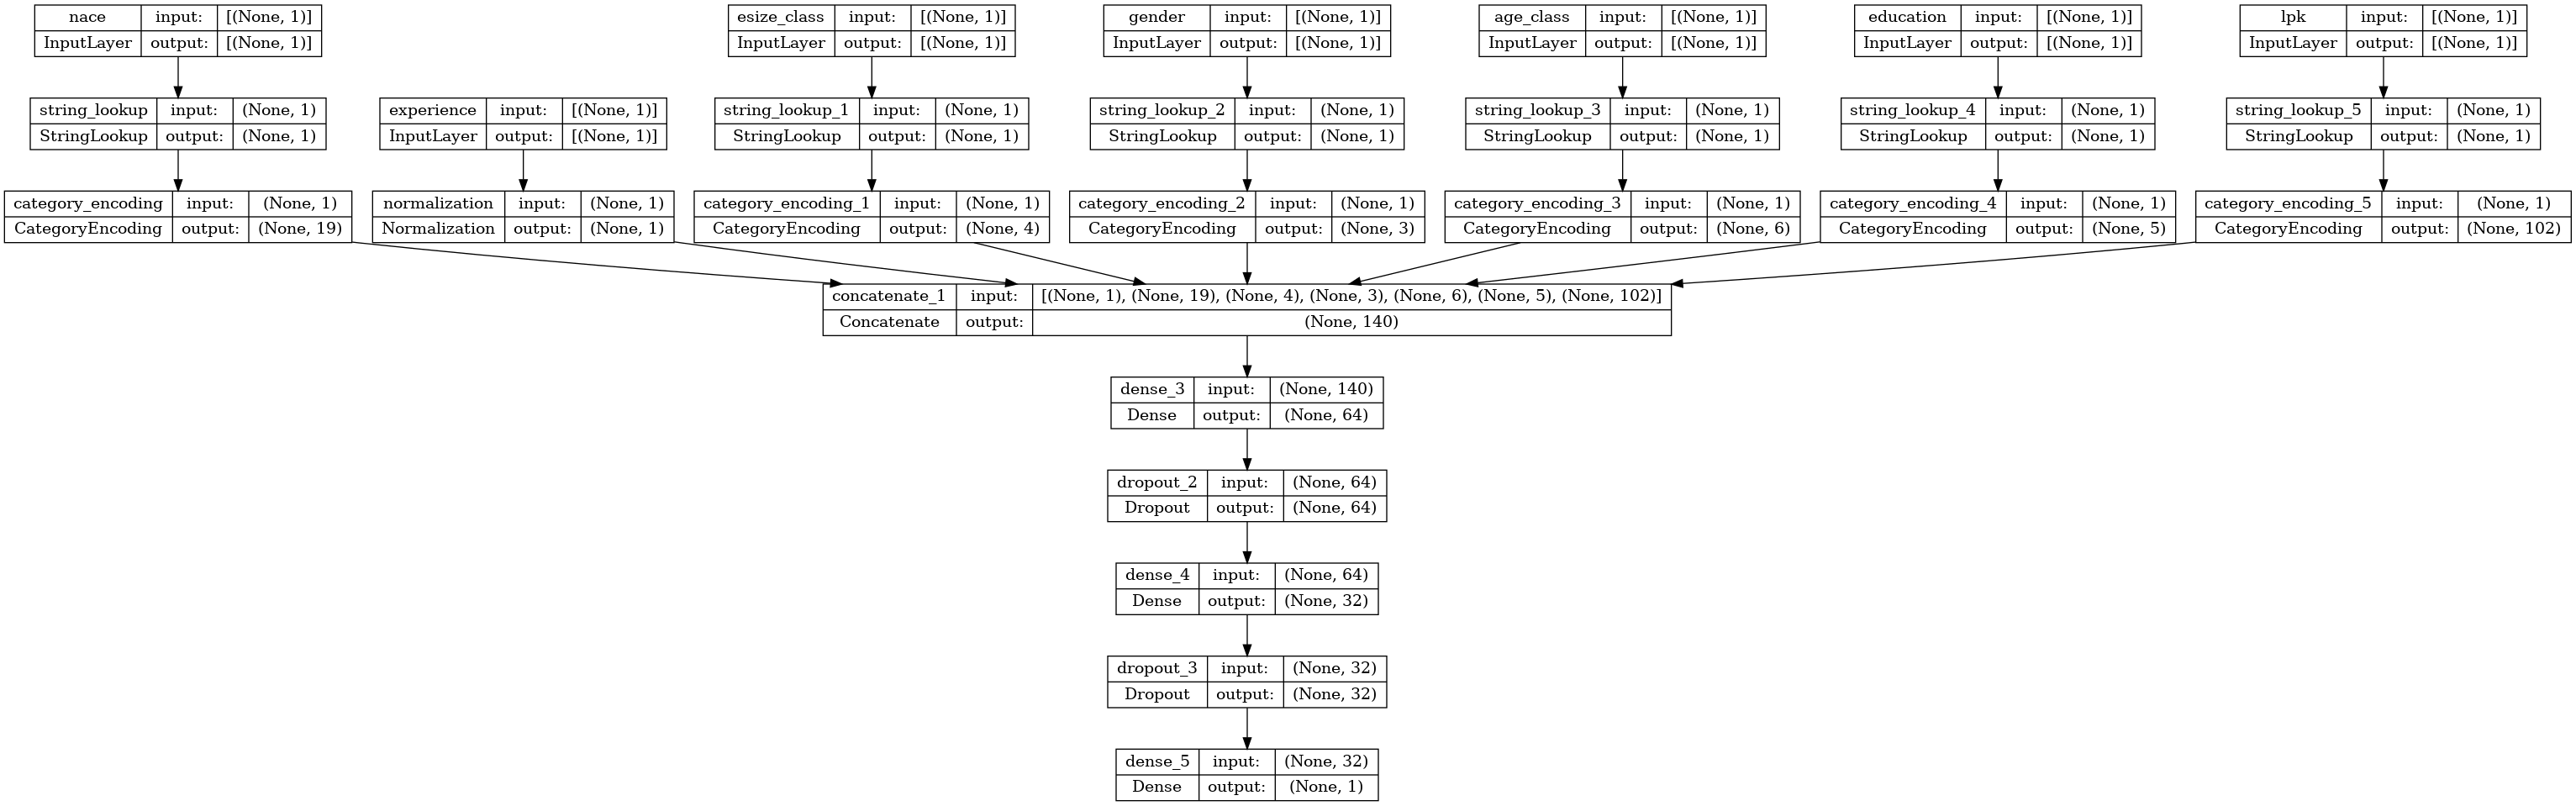

In [32]:
tf.keras.utils.plot_model(model, rankdir="TB", show_shapes=True)

In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=30, 
    restore_best_weights=True,
)

history = model.fit(train_ds,
    validation_data=val_ds,
    epochs=300,
    callbacks=[early_stopping],
    verbose=0
)

Minimum validation RMSE: 1.688956618309021


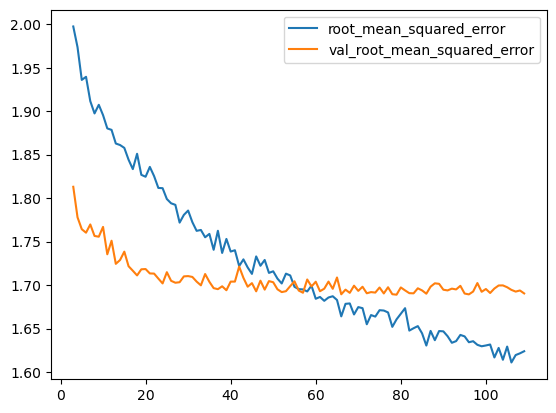

In [34]:
history_df = pd.DataFrame(history.history)
history_df.loc[3:, ['root_mean_squared_error', 'val_root_mean_squared_error']].plot();
print("Minimum validation RMSE: {}".format(history_df['val_root_mean_squared_error'].min()))

In [35]:
loss, rmse = model.evaluate(test_ds)

26/26 [==============================] - 0s 1ms/step - loss: 2.5828 - root_mean_squared_error: 1.6001


In [36]:
model.save('./Models/tf_model/')

INFO:tensorflow:Assets written to: ./Models/tf_model/assets


INFO:tensorflow:Assets written to: ./Models/tf_model/assets
